In [11]:
import pandas as pd
import re
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Pytorch
import torch
import torch.nn as nn

# NLTK
from nltk.corpus import stopwords

# Fasttext utils: https://fasttext.cc/docs/en/crawl-vectors.html
import fasttext.util

fasttext.util.download_model("en", if_exists="ignore")  # English

# Model
from models.model import LSTM

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
class TrainTestStockPriceDatasetClass:
    def __init__(self):
        self.path = "./data/tesla_3_months_news_stock_price_data_3_days_1_delta.csv"
        self.raw_data = None
        self.ft = fasttext.load_model("cc.en.300.bin")
        self.min_word_count_required = 1
        self.max_word_count_acceptable = 4

    def loadRawData(self):
        self.raw_data = pd.read_csv(self.path)
        return self.raw_data

    def cleanRawData(self):
        for index, row in self.raw_data.iterrows():
            (
                self.raw_data["description"][index],
                word_count_list,
            ) = self.cleanTextUsingNLTK(row["description"])
            #             print(
            #                 "\n\n see this -> ",
            #                 self.raw_data["description"][index],
            #                 word_count_list,
            #             )
            self.raw_data["description"][index] = self.convert_sentence_to_embeddings(
                self.raw_data["description"][index]
            )

    #             print("\n Word embeddsings -> ", self.raw_data["description"][index])
    #             print("\n The result -> ", self.raw_data["price_delta_of_stock"][index])

    def cleanTextUsingNLTK(self, text):
        text = [word for word in re.split(r"\W+", text) if word.isalpha()]
        clean_text = [
            word.lower() for word in text if word not in set(stopwords.words("english"))
        ]
        word_count_list = self.findWordCount(clean_text)
        clean_text, word_count_list = self.filterListWithWordCount(
            clean_text, word_count_list
        )
        return clean_text, word_count_list

    def convert_sentence_to_embeddings(self, sentence):
        sentence_embeddings = []
        for word_index, word in enumerate(sentence):
            if word_index == 10:
                break
            sentence_embeddings += list(self.ft.get_word_vector(word))
        #             Todo: Append dummy vectors if length of the sentence less than certain threshold
        return torch.Tensor(sentence_embeddings)

    def findWordCount(self, sentence_in_list_type):
        unique_word_list_dict = defaultdict(int)
        for word in sentence_in_list_type:
            unique_word_list_dict[word] += 1
        return unique_word_list_dict

    def filterListWithWordCount(self, sentence_in_list_type, word_count_list):
        for word, word_prescence_count in word_count_list.items():
            if (
                word_prescence_count <= self.min_word_count_required
                or word_prescence_count >= self.max_word_count_acceptable
            ):
                sentence_in_list_type = [
                    word_from_sentence
                    for word_from_sentence in sentence_in_list_type
                    if word_from_sentence != word
                ]
        return sentence_in_list_type, {
            word: word_count_list[word]
            for word in word_count_list
            if word_count_list[word] > self.min_word_count_required
            and word_count_list[word] < self.max_word_count_acceptable
        }

    def RetrieveTrainingDataAndLabel(self):
        return self.raw_data["description"], self.raw_data["price_delta_of_stock"]

<IPython.core.display.Javascript object>

In [4]:
train_test_stock_price_dataset_class = TrainTestStockPriceDatasetClass()
data = train_test_stock_price_dataset_class.loadRawData()
train_test_stock_price_dataset_class.cleanRawData()
train_X, train_Y = train_test_stock_price_dataset_class.RetrieveTrainingDataAndLabel()

<ipython-input-3-41ccc553e032>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data["description"][index],
<ipython-input-3-41ccc553e032>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data["description"][index] = self.convert_sentence_to_embeddings(


<IPython.core.display.Javascript object>

In [5]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<IPython.core.display.Javascript object>

epoch: 1, loss: 0.007338017225265503
epoch: 16, loss: 0.007338096387684345
epoch: 31, loss: 0.007338807452470064
epoch: 46, loss: 0.0073391832411289215
epoch: 61, loss: 0.007337505463510752
epoch: 76, loss: 0.0073390076868236065
epoch: 91, loss: 0.007337337359786034
epoch: 106, loss: 0.007337331306189299
epoch: 121, loss: 0.007337391376495361
epoch: 136, loss: 0.007337410002946854
epoch: 151, loss: 0.0073374551720917225
epoch: 166, loss: 0.00733746774494648
epoch: 181, loss: 0.007337333634495735
epoch: 196, loss: 0.007337778806686401
epoch: 211, loss: 0.007339824456721544
epoch: 226, loss: 0.00733954505994916
epoch: 241, loss: 0.007339713629335165
epoch: 256, loss: 0.007343198172748089
epoch: 271, loss: 0.007337372284382582
epoch: 286, loss: 0.007337342016398907
epoch: 301, loss: 0.007337933871895075
epoch: 316, loss: 0.007337502669543028
epoch: 331, loss: 0.007337317336350679
epoch: 346, loss: 0.007337361574172974
epoch: 361, loss: 0.007337425369769335
epoch: 376, loss: 0.007337515708

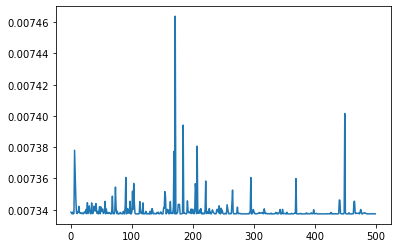

<IPython.core.display.Javascript object>

In [14]:
epochs = 500
loss_per_epoch_list = []
for i in range(epochs):
    for index, train_x in enumerate(train_X):
        train_x = train_x.view(1, -1)
        #         print("epoch number: ", i, train_x.shape, train_X[index].shape, train_Y[index])

        optimizer.zero_grad()
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size),
        )
        y_pred = model(train_x)

        single_loss = loss_function(y_pred, train_x)
        single_loss.backward()
        optimizer.step()
    loss_per_epoch_list.append(single_loss.item())
    if i % 15 == 1:
        print("epoch: {}, loss: {}".format(i, single_loss.item()))
# print(loss_per_epoch_list)
plt.plot(loss_per_epoch_list)
plt.show()